# Library & Dataset Import 

In [1]:
!pip install pytorch-lightning
!pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 705 kB 14.7 MB/s 
     |████████████████████████████████| 419 kB 76.7 MB/s 
     |████████████████████████████████| 5.9 MB 59.1 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
!pip install tqdm
from tqdm import tqdm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gc

# Torch and Sklearn
import pytorch_lightning as pl
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Metric
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
import torch.nn.functional as F
from torch import nn, Tensor
from torchmetrics.utilities import rank_zero_warn

# Typing 
from typing import Optional

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# 修改当前文件夹位置 假定notebook文件就在项目文件夹根目录
import os
def get_root_dir():
    if os.path.exists('/content/drive/MyDrive/'):
        # return '/content/drive/MyDrive/Colab/4-AMEX/AMEX Project/notebooks' #在Colab里
        return '/content/drive/MyDrive/AMEX Project/notebooks' # siyi path
    else:
        return './' #在本地

#调用系统命令，相当于cd，但是直接!cd是不行的
os.chdir(get_root_dir())

In [8]:
# File system
# train_file   = "../data/4-PreCompressed/FilledWithMean/Train-Mean(Pre-Compressed).parquet"
train_file   = "../data/4-PreCompressed/FilledWithRandomForest/train_RandomForest(PreCompressed).parquet"
train_label = "../data/1-original-data/train_labels.csv"
test_file   = "../data/4-PreCompressed/FilledWithRandomForest/test_RandomForest(PreCompressed).parquet"
model_output_folder = './experiment'

# Data
batch_size   = 1028
num_workers  = 4
epochs = 5

# Model 
in_features=188
hidden_dim=128
num_layers=2
learning_rate=1e-3

# Check whether each customer has 13 records

## Train Dataset Part

In [9]:
train_labels = pd.read_csv(train_label)
print(train_labels.shape)
print(train_labels['target'].value_counts())
train_labels.head(2)

(458913, 2)
0    340085
1    118828
Name: target, dtype: int64


,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0


In [10]:
train_df = pd.read_parquet(train_file, engine = 'pyarrow')
print(train_df.shape)
len(train_df.columns)
train_df.shape[0]

(5531451, 173)


5531451

In [11]:
pd.set_option('display.max_columns', None)
train_df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_64,D_65,B_16,B_17,B_18,B_19,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_30,S_18,D_86,R_17,R_18,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_111,D_112,B_40,S_27,D_113,D_114,D_115,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,0.041409,0,6,0.708906,0.170600,0,0.358587,0.525351,0.255736,-1,0.063902,0.059416,0.0,0.148698,4,0.008207,0,0.207334,0.736463,0.096219,0.010746,0.023381,0.002768,0,1.0,0,0.161345,0.148266,2896,0.354596,0.152025,0.118075,0,0.158612,0.065728,0.018385,8,0.199617,0.308233,0.016361,15,0.091071,0,0,0,0.201471,0.652984,0,0,6,0.272008,0.008363,524,0.002644,0.009013,0,0,0.119403,0,4,0.050882,0.0,1,1,0.004327,0.0,0.085788,0.007729,0.000272,0,0,0,-1,0.002271,0,0,0,0.002310,0,1,0.008033,1.0,0.084683,0,0,0.0,0,0,0,0,0,0,0,0,0.002537,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1,1.004587,0.893734,-1,2,0.009968,0.004572,-1,1.008949,2,-1,0,-1,1.0,0.210060,0.676922,0,1,0.238250,5,0.232120,0.236266,0,0.702280,3,0,16,0,1,1.007819,1,0,0.0,0.0,0.004345,0,-1,-1,-1,-1,0,0,0.0,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,0.041409,0,5,0.712795,0.113239,0,0.353630,0.521311,0.223329,-1,0.065261,0.057744,0.0,0.149723,4,0.008373,0,0.202778,0.720886,0.099804,0.010746,0.030599,0.002749,0,1.0,0,0.140951,0.143530,2896,0.326757,0.156201,0.118737,0,0.148459,0.093935,0.013035,8,0.151387,0.265026,0.017688,15,0.086805,0,0,0,0.201471,0.647093,0,0,6,0.188970,0.004030,524,0.004193,0.007842,0,0,0.140611,0,4,0.040469,0.0,1,1,0.004203,0.0,0.084307,0.001864,0.000979,0,0,0,-1,0.009810,0,0,0,0.001327,0,1,0.000760,1.0,0.081843,0,0,0.0,0,0,0,0,0,0,0,0,0.008427,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.902135,0.136333,0.919876,0.975625,0.004561,0.786007,1,1.004118,0.906841,-1,2,0.003921,0.004654,-1,1.003205,2,-1,0,-1,1.0,0.184093,0.822281,0,1,0.247217,5,0.243532,0.241885,0,0.707017,3,0,16,0,1,1.004333,1,0,0.0,0.0,0.007495,0,-1,-1,-1,-1,0,0,0.0,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,0.041409,0,5,0.720884,0.060492,0,0.334650,0.524568,0.189424,-1,0.066982,0.056647,0.0,0.151955,4,0.009355,0,0.206629,0.738044,0.134073,0.010746,0.048367,0.010077,0,1.0,0,0.112229,0.137014,3166,0.304124,0.153795,0.114534,0,0.139504,0.084757,0.056653,8,0.305883,0.212165,0.063955,15,0.094001,0,0,0,0.201471,0.645819,0,0,6,0.495308,0.006838,702,0.001337,0.006025,0,0,0.075868,0,4,0.047454,0.0,1,1,0.001782,0.0,0.089963,0.005419,0.006149,0,0,0,-1,0.009362,0,0,0,0.007624,0,1,0.004056,1.0,0.081954,0,0,0.0,0,0,0,0,0,0,0,0,0.007327,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.939654,0.134938,0.958699,0.974067,0.011736,0.806840,1,1.009285,0.928719,-1,2,0.001264,0.019176,-1,1.000754,2,-1,0,-1,1.0,0.154837,0.853498,0,1,0.239867,5,0.240768,0.239710,0,0.704843,3,0,16,0,1,1.007831,1,0,0.0,0.0,0.009227,0,-1,-1,-1,-1,0,0,0.0,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,0.041409,0,4,0.723997,0.166782,0,0.323271,0.530929,0.135586,-1,0.083720,0.049253,0.0,0.151219,4,0.006782,0,0.208214,0.741813,0.134437,0.010746,0.030063,0.009667,0,1.0,0,0.

In [12]:
temp = train_df.groupby("customer_ID").count()
# Customers with less than 13 records in the dataset
id_list = temp[temp['S_2'] != 13].index
temp = temp[temp['S_2'] != 13].iloc[:,:1]
temp.reset_index().head()

,customer_ID,S_2
0,0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba17...,3
1,000391f219520dbca6c3c1c46e0fab569da163f79ee266...,4
2,0004860c260168fcaad0734a1dfedb7ceb1a83aaac54e2...,9
3,00057c2d8d887fa3f777d97dc939700731575772e6c990...,4
4,0005a6ae24fd274640a237ea56c43b1ef9e32077ad168a...,12


In [13]:
# Number of good 
df_cd = pd.merge(temp, train_labels, how='inner', on = 'customer_ID')
df_cd

,customer_ID,S_2,target
0,0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba17...,3,1
1,000391f219520dbca6c3c1c46e0fab569da163f79ee266...,4,1
2,0004860c260168fcaad0734a1dfedb7ceb1a83aaac54e2...,9,1
3,00057c2d8d887fa3f777d97dc939700731575772e6c990...,4,0
4,0005a6ae24fd274640a237ea56c43b1ef9e32077ad168a...,12,0
...,...,...,...
72874,fffe13e28dc3ceadf28249b596ba25df93e38ec53d38cf...,3,0
72875,fffe2bc02423407e33a607660caeed076d713d8a5ad323...,8,1
72876,fffe5008118592b867d89647fc840c45858860f596d98b...,2,1
72877,fffec7d7e1ca804c86f1ffdaac389c33f8039ed35bf412...,7,0


In [17]:
# IDs of good customers with missing values
gm = df_cd[df_cd['target'] == 1]['customer_ID']

# IDs of bad customers with missing values
bad = df_cd[df_cd['target'] == 0]
bm = bad['customer_ID']

gm

0        0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba17...
1        000391f219520dbca6c3c1c46e0fab569da163f79ee266...
2        0004860c260168fcaad0734a1dfedb7ceb1a83aaac54e2...
5        0005e52a3fa31b7eed49ceb576f011433ee2578833cd3f...
6        0005ef1480ffe4f0e5908eae07db8e05f2e705bca6a57d...
                               ...                        
72866    fff7823e4d54f56a43340a2d63294e106f25c44a4385cc...
72870    fffac44d9cf2cce85f5ac7a228d6a7c0b875f074c89a6c...
72872    fffd4c8532e6746a53dfdd52de2219c847ddb0123c27cc...
72875    fffe2bc02423407e33a607660caeed076d713d8a5ad323...
72876    fffe5008118592b867d89647fc840c45858860f596d98b...
Name: customer_ID, Length: 29350, dtype: object

## Delete all good customer records from train_df with missing values [train_df2]
Keep the records of bad customers!!!

In [22]:
print(train_df.shape)
print(len(gm))
train_df2 = train_df[~train_df['customer_ID'].isin(gm)]
train_df2.shape

(5531451, 173)
29350


(5316796, 173)

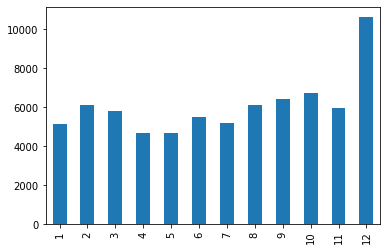

In [ ]:
# barh for horizontal
df_cd['S_2'].value_counts().sort_index(ascending=True).plot(kind='bar')

In [ ]:
print("Number of good customers with less than 13 records: ", df_cd[df_cd['target'] == 0]['target'].count())
print("Ratio of missing records among good customers: ", '{:.1%}'.format(df_cd[df_cd['target'] == 0]['target'].count()/340085))
print("Number of bad customers with less than 13 records: ", df_cd[df_cd['target'] == 1]['target'].count())
print("Ratio of missing records among bad customers: ", '{:.1%}'.format(df_cd[df_cd['target'] == 1]['target'].count()/118828))

Number of good customers with less than 13 records:  43529
Ratio of missing records among good customers:  12.8%
Number of bad customers with less than 13 records:  29350
Ratio of missing records among bad customers:  24.7%


## Test Dataset Part

In [ ]:
test_df = pd.read_parquet(test_file, engine = 'pyarrow')
print(test_df.shape)

(11363762, 173)


In [ ]:
test_df.head()
test_df.shape

(11363762, 173)

In [ ]:
temp = test_df.groupby("customer_ID").count()
# Customers with less than 13 records in the dataset
id_list = temp[temp['S_2'] != 13].index
temp = temp[temp['S_2'] != 13].iloc[:,:1]
temp.reset_index().head()

,customer_ID,S_2
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,9
1,00018b499469c9f10a1b428cbcf7419efa4b3336e6dd78...,12
2,0002b4b7a4f5b165bc71794ba473cc5bfa2267c7bf8f6e...,7
3,000311b99b226f7bf3a032671edb917f8a4edf98ab06ac...,12
4,00034153f0d5a7e474b05799e9ca6d30fa7008065b1958...,10


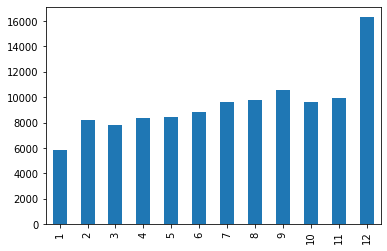

In [ ]:
# barh for horizontal
temp['S_2'].value_counts().sort_index(ascending=True).plot(kind='bar')

In [ ]:
print("Number of customers with less than 13 records: ", temp['S_2'].count())
print("Ratio of customers with less than 13 records: ", '{:.1%}'.format(temp['S_2'].count()/test_df.shape[0]))

Number of customers with less than 13 records:  113292
Ratio of customers with less than 13 records:  1.0%


In [ ]:
len(train_df['customer_ID'].unique())

458913

# Fill the Missing Values for Bad Customers in train_df and test_df

In [23]:
train_df2.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_64,D_65,B_16,B_17,B_18,B_19,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_30,S_18,D_86,R_17,R_18,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_111,D_112,B_40,S_27,D_113,D_114,D_115,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,0.041409,0,6,0.708906,0.170600,0,0.358587,0.525351,0.255736,-1,0.063902,0.059416,0.0,0.148698,4,0.008207,0,0.207334,0.736463,0.096219,0.010746,0.023381,0.002768,0,1.0,0,0.161345,0.148266,2896,0.354596,0.152025,0.118075,0,0.158612,0.065728,0.018385,8,0.199617,0.308233,0.016361,15,0.091071,0,0,0,0.201471,0.652984,0,0,6,0.272008,0.008363,524,0.002644,0.009013,0,0,0.119403,0,4,0.050882,0.0,1,1,0.004327,0.0,0.085788,0.007729,0.000272,0,0,0,-1,0.002271,0,0,0,0.002310,0,1,0.008033,1.0,0.084683,0,0,0.0,0,0,0,0,0,0,0,0,0.002537,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1,1.004587,0.893734,-1,2,0.009968,0.004572,-1,1.008949,2,-1,0,-1,1.0,0.210060,0.676922,0,1,0.238250,5,0.232120,0.236266,0,0.702280,3,0,16,0,1,1.007819,1,0,0.0,0.0,0.004345,0,-1,-1,-1,-1,0,0,0.0,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,0.041409,0,5,0.712795,0.113239,0,0.353630,0.521311,0.223329,-1,0.065261,0.057744,0.0,0.149723,4,0.008373,0,0.202778,0.720886,0.099804,0.010746,0.030599,0.002749,0,1.0,0,0.140951,0.143530,2896,0.326757,0.156201,0.118737,0,0.148459,0.093935,0.013035,8,0.151387,0.265026,0.017688,15,0.086805,0,0,0,0.201471,0.647093,0,0,6,0.188970,0.004030,524,0.004193,0.007842,0,0,0.140611,0,4,0.040469,0.0,1,1,0.004203,0.0,0.084307,0.001864,0.000979,0,0,0,-1,0.009810,0,0,0,0.001327,0,1,0.000760,1.0,0.081843,0,0,0.0,0,0,0,0,0,0,0,0,0.008427,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.902135,0.136333,0.919876,0.975625,0.004561,0.786007,1,1.004118,0.906841,-1,2,0.003921,0.004654,-1,1.003205,2,-1,0,-1,1.0,0.184093,0.822281,0,1,0.247217,5,0.243532,0.241885,0,0.707017,3,0,16,0,1,1.004333,1,0,0.0,0.0,0.007495,0,-1,-1,-1,-1,0,0,0.0,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,0.041409,0,5,0.720884,0.060492,0,0.334650,0.524568,0.189424,-1,0.066982,0.056647,0.0,0.151955,4,0.009355,0,0.206629,0.738044,0.134073,0.010746,0.048367,0.010077,0,1.0,0,0.112229,0.137014,3166,0.304124,0.153795,0.114534,0,0.139504,0.084757,0.056653,8,0.305883,0.212165,0.063955,15,0.094001,0,0,0,0.201471,0.645819,0,0,6,0.495308,0.006838,702,0.001337,0.006025,0,0,0.075868,0,4,0.047454,0.0,1,1,0.001782,0.0,0.089963,0.005419,0.006149,0,0,0,-1,0.009362,0,0,0,0.007624,0,1,0.004056,1.0,0.081954,0,0,0.0,0,0,0,0,0,0,0,0,0.007327,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.939654,0.134938,0.958699,0.974067,0.011736,0.806840,1,1.009285,0.928719,-1,2,0.001264,0.019176,-1,1.000754,2,-1,0,-1,1.0,0.154837,0.853498,0,1,0.239867,5,0.240768,0.239710,0,0.704843,3,0,16,0,1,1.007831,1,0,0.0,0.0,0.009227,0,-1,-1,-1,-1,0,0,0.0,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,0.041409,0,4,0.723997,0.166782,0,0.323271,0.530929,0.135586,-1,0.083720,0.049253,0.0,0.151219,4,0.006782,0,0.208214,0.741813,0.134437,0.010746,0.030063,0.009667,0,1.0,0,0.

## Fill train_df

In [28]:
sorted(train_df2['S_2'].unique())
print(train_df2['S_2'].min())
print(train_df2['S_2'].max())

2017-03-01
2018-03-31


In [50]:
# Records need to be copied and the dates of these records
# copying_records still contain 13 records customer, so need to check whether the index is inside bad customer ids
copying_records = train_df2.groupby("customer_ID")['S_2'].max()
type(copying_records)

pandas.core.series.Series

In [92]:
copying_records

customer_ID
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a    2018-03-13
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5    2018-03-25
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1    2018-03-12
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc    2018-03-29
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed    2018-03-30
                                                                       ...    
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7    2018-03-31
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286    2018-03-22
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6    2018-03-07
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145b2c3d01967fcce461    2018-03-23
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681    2018-03-14
Name: S_2, Length: 429563, dtype: object

In [43]:
copying_records.index
copying_records[copying_records.index[0]]

'2018-03-13'

In [38]:
df_cd.head()
df_cd['times_to_repeat'] = np.nan
df_cd['times_to_repeat'] = df_cd['S_2'].apply(lambda x: 13 - x)
df_cd.head()

,customer_ID,S_2,target,times_to_repeat
0,0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba17...,3,1,10
1,000391f219520dbca6c3c1c46e0fab569da163f79ee266...,4,1,9
2,0004860c260168fcaad0734a1dfedb7ceb1a83aaac54e2...,9,1,4
3,00057c2d8d887fa3f777d97dc939700731575772e6c990...,4,0,9
4,0005a6ae24fd274640a237ea56c43b1ef9e32077ad168a...,12,0,1


In [56]:
df_repeat = df_cd.set_index('customer_ID')['times_to_repeat']
df_repeat['0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba1730b2849b92ea687f9e']

10

In [66]:
bm.unique()

array(['00057c2d8d887fa3f777d97dc939700731575772e6c99025aaa0ab56870353ce',
       '0005a6ae24fd274640a237ea56c43b1ef9e32077ad168a90d464dcf2bd5976fb',
       '00062483fb33d6129dd4ee7e5a12f751d2e7010ac0df0178997c628883695603',
       ...,
       'fffe13e28dc3ceadf28249b596ba25df93e38ec53d38cf28ee13d50d4b7b1a22',
       'fffec7d7e1ca804c86f1ffdaac389c33f8039ed35bf412b12d2e3548e49d54fa',
       'fffee056e120fb326c9413fca5a7ab6618cc49be9bb6b19c34f3fb13fd50fdd3'],
      dtype=object)

In [67]:
'00057c2d8d887fa3f777d97dc939700731575772e6c99025aaa0ab56870353ce' in bm.unique()

True

In [ ]:
train_df_filled = train_df2

# id is the customer_ID, which is the index of a Series
for id in tqdm(copying_records.index):
  if (id in bm.unique()):
    date = copying_records[id]
    times = df_repeat[id]
    # print(times)
    copy_row = train_df2[(train_df2['customer_ID'] == id) & (train_df2['S_2'] == date)]
    # print(copy_row)
    train_df_filled = train_df_filled.append([copy_row]*times, ignore_index=True)

print(train_df2.shape, train_df_filled.shape)

Create a new dataframe to append and concate with the original dataframe

df_filled = pd.DataFrame()

-id is the customer_ID, which is the index of a Series
for id in tqdm(copying_records.index):
  if (id in bm.unique()):
    date = copying_records[id]
    times = df_repeat[id]
    print(times)
    copy_row = train_df2[(train_df2['customer_ID'] == id) & (train_df2['S_2'] == date)]
    print(copy_row)
    df_filled = df_filled.append([copy_row]*times, ignore_index=True)

train_df_filled = train_df2.concat(df_filled)
print(train_df2.shape, train_df_filled.shape)

In [ ]:
df_filled = pd.DataFrame()

# id is the customer_ID, which is the index of a Series
for id in tqdm(bm):
  date = copying_records[id]
  times = df_repeat[id]
  # print(date, times)
  copy_row = train_df2[(train_df2['customer_ID'] == id) & (train_df2['S_2'] == date)]
  # print(copy_row)
  df_filled = df_filled.append([copy_row]*times, ignore_index=True)

train_df_filled = pd.concat([train_df2, df_filled])
print(train_df2.shape, train_df_filled.shape)

 43%|████▎     | 18754/43529 [4:00:08<5:17:54,  1.30it/s]

In [78]:
train_df2[-1:]

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_64,D_65,B_16,B_17,B_18,B_19,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_30,S_18,D_86,R_17,R_18,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_111,D_112,B_40,S_27,D_113,D_114,D_115,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145
5531450,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-03-14,0.982175,0,0.000077,0.99288,0.000809,0.119165,0.0,0.014092,0.013455,0,1,0.750784,0.006617,0,0.459745,0.53161,0.018577,-1,0.233117,0.028185,0.0,0.088608,0,0.001976,0,0.281229,0.611945,0.291345,0.010746,0.00458,0.005654,0,1.0,0,0.065466,0.028086,0,0.025615,0.142516,0.048498,0,0.01671,0.005854,0.008614,19,0.023136,-0.003556,0.003001,12,0.07883,0,0,7,0.003771,0.689411,0,0,5,0.191495,0.009614,0,0.007091,0.004388,0,1,0.013747,0,8,0.017935,0.0,1,1,0.00593,0.0,0.077725,0.002918,0.000045,0,0,0,-1,0.007231,0,0,0,0.002365,0,1,0.002432,1.0,0.016145,0,0,0.0,0,0,0,0,0,0,0,0,0.006033,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.295251,0.131636,0.080514,0.97469,0.005346,0.003459,0,0.0,0.000325,-1,0,0.007781,0.008004,-1,1.005181,3,-1,0,-1,1.0,0.051741,0.000568,1,1,0.037532,4,0.037342,0.033036,0,0.728418,3,0,11,0,1,1.005669,1,0,0.0,0.0,0.006312,0,-1,-1,-1,-1,0,0,0.0,0,0.003184,0


## Fill test_df

# LSTM Embedding

In [ ]:
tf.ones((3, 3))

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)>

In [ ]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((3, 3)) # generate a 3*3 dimension matrix
y = model(x)
y

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 0.0674468 , -0.4333192 ,  0.05436861, -1.7023029 ],
       [ 0.0674468 , -0.4333192 ,  0.05436861, -1.7023029 ],
       [ 0.0674468 , -0.4333192 ,  0.05436861, -1.7023029 ]],
      dtype=float32)>

In [ ]:
# Create 3 layers
layer1 = layers.Dense(2, activation="relu", name="layer1")
layer2 = layers.Dense(3, activation="relu", name="layer2")
layer3 = layers.Dense(4, name="layer3")

# Call layers on a test input
x = tf.ones((3, 3))
y = layer3(layer2(layer1(x)))

In [ ]:
inputs = tf.random.normal([32, 10, 8])
lstm = tf.keras.layers.LSTM(4)
output = lstm(inputs)
print(output.shape)
lstm = tf.keras.layers.LSTM(4, return_sequences=True, return_state=True)
whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)
print(whole_seq_output.shape)
print(final_memory_state.shape)
print(final_carry_state.shape)

(32, 4)
(32, 10, 4)
(32, 4)
(32, 4)


In [ ]:
inputs = tf.random.normal([2, 10, 8])
lstm = tf.keras.layers.LSTM(4)
output = lstm(inputs)
print(inputs)
output

tf.Tensor(
[[[ 0.21228519  0.2040778  -0.15244062 -0.20346579 -0.25174865
   -1.5891948  -0.9023612  -0.7409139 ]
  [ 1.2737958   0.4708495   0.34705764 -0.96710795 -0.18102032
    0.83140075 -0.4807229  -0.5658455 ]
  [ 0.37889186 -1.6369596   0.7182438  -1.5544063   0.36376703
    0.04401025 -0.02689494  0.759924  ]
  [-0.5077046  -1.3813028  -0.00248839 -0.02301835  1.2097633
    0.9591774   1.1742088   1.042522  ]
  [-1.5099784   0.24550289 -1.7807925   1.1469606  -1.849255
   -0.01233645 -0.29803813 -1.9333289 ]
  [ 0.7665701  -1.6125464   0.71154594 -0.03893887 -0.5340092
    0.25914893  0.8059235   0.06590413]
  [ 0.15721224 -0.10317574 -1.538134   -1.5391849  -0.15337375
    1.5866102   0.10848363 -0.62247443]
  [ 0.7283299  -2.106077    1.0384902  -0.36902994 -2.4055946
    1.2485439   1.8009294   0.04559383]
  [ 1.5044062   0.84354234  1.3032435  -0.42049193 -0.46448976
    0.5749678   0.14437935  0.42498547]
  [ 1.079916   -1.0824186  -0.50574857  1.9528047  -1.4184017
   -1

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 0.47486964, -0.22987616,  0.36588925,  0.25671464],
       [ 0.07636937, -0.2506345 , -0.02750085, -0.16058859]],
      dtype=float32)>